In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import sgd,adam,rmsprop
from keras.wrappers.scikit_learn import KerasClassifier # classifier model
from keras.utils import to_categorical, np_utils
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, GridSearchCV # for finding best parameters
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random
import os
import time

Using TensorFlow backend.


# PRE-PROCESSING PHASE

In [2]:
#Getting the data from directory and categorizing it

filenames = os.listdir("..\\Dogs and Cats\\Project3_files\\data\\train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append("cat")
    else:
        categories.append("dog")
X_train = pd.DataFrame({"filename": filenames, "category": categories})

In [3]:
y_train = pd.DataFrame({"category": categories})

#### Gain Insights and See an Example Image

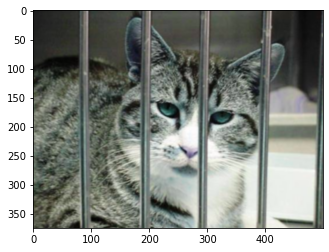

In [4]:
first_image = cv2.imread('..\\Dogs and Cats\\Project3_files\\data\\train\\cat.17.jpg')
plt.imshow(first_image, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

#### Image Resizing

In [5]:
IMAGE_WIDTH=150
IMAGE_HEIGHT =150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

#### Image Rescaling

In [6]:
train_directory = "..\\Dogs and Cats\\Project3_files\\data\\train"
BATCH_SIZE = 50
train_datagenerator = ImageDataGenerator(rescale=1./255) # rescaling images
train_generator = train_datagenerator.flow_from_dataframe(X_train,
                                                          train_directory,
                                                          x_col = "filename",
                                                          y_col = "category",
                                                          target_size = IMAGE_SIZE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "binary")
X_train, y_train = next(train_generator)

Found 1002 validated image filenames belonging to 2 classes.


# TRAINING PHASE

In [7]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

print("...Building Model...")
start = time.time()

def create_model(optimizer='rmsprop',init_mode='uniform'):
    # Initialising the CNN
    model = Sequential()
    # Convolution
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    # pooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Memorising
    model.add(Dropout(rate=0.2))
    
    # Second convolutional layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2)) 
    #Flattening
    model.add(Flatten())
    # Full connection
    model.add(Dense(256, kernel_initializer=init_mode,activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(1, kernel_initializer=init_mode,activation='sigmoid')) # this is a binary classification so 
                                                    # i choose to use the sigmoid function
    # compiling the CNN
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

model = KerasClassifier(build_fn = create_model,batch_size = 50, verbose = 0)
# creating parameters for search
epochs = [3,5,10]
optimizers = ['rmsprop', 'adam']
init_mode = ['uniform', 'normal', 'glorot_uniform']

param_grid = dict(init_mode = init_mode, optimizer=optimizers,epochs=epochs)
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv=3,verbose = 3)


grid_result = grid.fit(X_train, y_train)
print("> Completion Time : ", time.time() - start)

...Building Model...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] epochs=3, init_mode=uniform, optimizer=rmsprop ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  epochs=3, init_mode=uniform, optimizer=rmsprop, score=0.471, total=   7.6s
[CV] epochs=3, init_mode=uniform, optimizer=rmsprop ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


[CV]  epochs=3, init_mode=uniform, optimizer=rmsprop, score=0.471, total=  10.7s
[CV] epochs=3, init_mode=uniform, optimizer=rmsprop ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.3s remaining:    0.0s


[CV]  epochs=3, init_mode=uniform, optimizer=rmsprop, score=0.562, total=  10.6s
[CV] epochs=3, init_mode=uniform, optimizer=adam .....................
[CV]  epochs=3, init_mode=uniform, optimizer=adam, score=0.471, total=  11.8s
[CV] epochs=3, init_mode=uniform, optimizer=adam .....................
[CV]  epochs=3, init_mode=uniform, optimizer=adam, score=0.529, total=  11.3s
[CV] epochs=3, init_mode=uniform, optimizer=adam .....................
[CV]  epochs=3, init_mode=uniform, optimizer=adam, score=0.562, total=  13.0s
[CV] epochs=3, init_mode=normal, optimizer=rmsprop ...................
[CV]  epochs=3, init_mode=normal, optimizer=rmsprop, score=0.471, total=  11.0s
[CV] epochs=3, init_mode=normal, optimizer=rmsprop ...................
[CV]  epochs=3, init_mode=normal, optimizer=rmsprop, score=0.471, total=  10.9s
[CV] epochs=3, init_mode=normal, optimizer=rmsprop ...................
[CV]  epochs=3, init_mode=normal, optimizer=rmsprop, score=0.562, total=  12.0s
[CV] epochs=3, init

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 19.3min finished


> Completion Time :  1176.2306780815125


#### Summarize Results

In [8]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.540000 using {'epochs': 3, 'init_mode': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.500000 (0.042875) with: {'epochs': 3, 'init_mode': 'uniform', 'optimizer': 'rmsprop'}
0.520000 (0.037924) with: {'epochs': 3, 'init_mode': 'uniform', 'optimizer': 'adam'}
0.500000 (0.042875) with: {'epochs': 3, 'init_mode': 'normal', 'optimizer': 'rmsprop'}
0.480000 (0.037924) with: {'epochs': 3, 'init_mode': 'normal', 'optimizer': 'adam'}
0.540000 (0.015435) with: {'epochs': 3, 'init_mode': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.500000 (0.042875) with: {'epochs': 3, 'init_mode': 'glorot_uniform', 'optimizer': 'adam'}
0.500000 (0.024254) with: {'epochs': 5, 'init_mode': 'uniform', 'optimizer': 'rmsprop'}
0.520000 (0.037924) with: {'epochs': 5, 'init_mode': 'uniform', 'optimizer': 'adam'}
0.500000 (0.042875) with: {'epochs': 5, 'init_mode': 'normal', 'optimizer': 'rmsprop'}
0.520000 (0.037924) with: {'epochs': 5, 'init_mode': 'normal', 'optimizer': 'adam'}
0.520000 (0.086840) with: {'epochs'

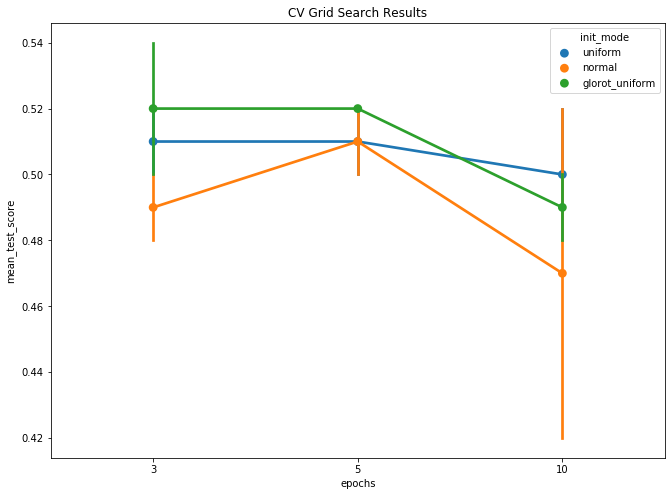

In [9]:
import pandas as pd

def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig
fig = plot_cv_results(grid_result.cv_results_, 'epochs', 'init_mode')

# Model Optimization Phase

In [10]:
# getting best parameters for the create best model
grid_result.best_params_

{'epochs': 3, 'init_mode': 'glorot_uniform', 'optimizer': 'rmsprop'}

In [11]:
def Tuned_model(optimizer='rmsprop',init_mode='glorot_uniform'):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2)) 
    
    model.add(Flatten())
    model.add(Dense(256, kernel_initializer=init_mode,activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(1, kernel_initializer=init_mode,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers, metrics=['accuracy'])

    return model
model = KerasClassifier(build_fn = create_model,batch_size = 50, verbose = 0)
epochs = [3]
optimizers = ['rmsprop']
init_mode = ['glorot_uniform']

param_grid = dict(init_mode = init_mode, epochs=epochs,optimizer=optimizers)
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv=3,verbose = 3)


tuned_grid = grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] epochs=3, init_mode=glorot_uniform, optimizer=rmsprop ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  epochs=3, init_mode=glorot_uniform, optimizer=rmsprop, score=0.529, total=  27.2s
[CV] epochs=3, init_mode=glorot_uniform, optimizer=rmsprop ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.1s remaining:    0.0s


[CV]  epochs=3, init_mode=glorot_uniform, optimizer=rmsprop, score=0.471, total=  12.2s
[CV] epochs=3, init_mode=glorot_uniform, optimizer=rmsprop ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   39.2s remaining:    0.0s


[CV]  epochs=3, init_mode=glorot_uniform, optimizer=rmsprop, score=0.438, total=  11.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   50.9s finished


#### Prepare Testing Data

In [12]:
test_files = os.listdir("..\\Dogs and Cats\\Project3_files\\data\\test")
df_test = pd.DataFrame({
    'filename': test_files
})

#### Create Testing Generator


In [13]:
test_directory = "..\\Dogs and Cats\\Project3_files\\data\\test"
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(df_test, 
                                              test_directory, 
                                              x_col='filename',
                                              y_col=None,
                                              class_mode=None,
                                              target_size=IMAGE_SIZE,
                                              batch_size=BATCH_SIZE,
                                             shuffle=False)
test_generator.reset()
y_test = next(test_generator)

Found 100 validated image filenames.


### Predict

In [14]:
predict = tuned_grid.predict(y_test)

In [18]:
first_image = cv2.imread('..\\Dogs and Cats\\Project3_files\\data\\test\\45.jpg')
image = cv2.resize(first_image, (150,150))
image = image.reshape(1, 150, 150, 3)

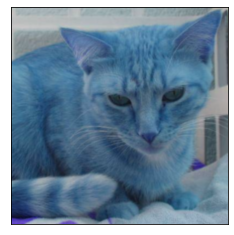

In [19]:
plt.imshow(first_image, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [20]:
result = tuned_grid.predict(image)
if(result[0][0] == 0):
    print("I guess this must be a Cat!")
else:
    print("I guess this must be a Dog!")

I guess this must be a Cat!
